### Time Series Forecasting for BPH with LSTMs in Keras in Keras  Prediction

link https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

### โครงข่ายประสาทเทียม เช่น Long Short-Term Memory (LSTM) โครงข่ายประสาทเทียมแบบเกิดซ้ำ สามารถสร้างแบบจำลองปัญหาได้เกือบจะต่อเนื่องกับตัวแปรอินพุตหลายตัว

-เเนวความคิดจากการทด

วิธีแปลงชุดข้อมูลดิบเป็นสิ่งที่เราสามารถใช้สำหรับการคาดการณ์อนุกรมเวลา
วิธีเตรียมข้อมูลและจัดวาง LSTM สำหรับปัญหาการพยากรณ์อนุกรมเวลาแบบหลายตัวแปร
วิธีพยากรณ์และปรับขนาดผลลัพธ์กลับเป็นหน่วยเดิม

เริ่มโครงการของคุณด้วยหนังสือเล่มใหม่ Deep Learning for Time Series Forecasting รวมถึงบทช่ Pythonสำหรับตัวอย่างทั้งหมด https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/วยสอนทีละขั้นตอนและไฟล์ซอร์สโค้ด

## Setup

In [28]:
import os
import datetime
import time

import IPython
import IPython.display
# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import clear_output

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from math import sqrt
from numpy import concatenate
import numpy as np
import math

import pandas as pd
from pandas import DataFrame
from pandas import concat

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import tensorflow 
import tensorflow as tf
from tensorflow import keras

import platform
# print(platform.python_version())
# print(tf.version.VERSION)
# print(np.__version__)

# setup parameter

In [29]:
# load model
path_adress_model_1 = ".\\Import_Model\\"
# path_adress_model_2 = "\\d2022-03-18_t17-17-59_14_lag_1-forecast\\"
# path_adress_model_2 = "\\d2022-02-27_t10-44-33_14_lag_3-forecast\\"
# path_adress_model_2 = "\\d2022-02-28_t15-08-32_14_lag_5-forecast\\"
path_adress_model_2 = "\\d2022-03-18_t23-24-36_14_lag_7-forecast\\"

# path_adress_model_3 = "\\model_lstm_d2022-03-18_t17-17-59_loss_0.00083\\" 
# path_adress_model_3 = "\\model_lstm_d2022-02-27_t10-44-33_loss_0.00058\\" 
# path_adress_model_3 = "\\model_lstm_d2022-02-28_t15-08-32_loss_0.00062\\" 
path_adress_model_3 = "\\model_lstm_d2022-03-18_t23-24-36_loss_0.00081\\" 

model_name = path_adress_model_1 + path_adress_model_2 + path_adress_model_3

# specify the number of lag hours
n_day = int(path_adress_model_2[23:25])
n_out = int(path_adress_model_2[30:31])


# Load model

In [30]:
## Load model
model_loaded = tf.keras.models.load_model(model_name)
model_loaded.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 53,301
Trainable params: 53,301
Non-trainable params: 0
_________________________________________________________________


## data Preparation 

In [31]:
## File name and Path
path_adress1 = ".\\template-Data Parameters Required for Brown planthopper\\"
path_adress2 = "\\station\\"
path_adress3 = ".\\Import_Dataset\\"

#ข้อมูล พิกัดสถานที่เเละรายชื้ออ้างอิงสถานที่ตรวจวัด
file_name_st = 'Data_lat_long_Rice research Center'
csv_file =path_adress1 + path_adress2 + file_name_st + '.csv'

df_st = pd.read_csv(csv_file)
print("All low RiceCenter {} station" .format(df_st.shape[0]))



All low RiceCenter 34 station


In [32]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### load data


In [33]:
# Preparing Pandas Dataframes for Machine Learning

def creat_dataset(st_BPH = 0, y_1 = '2015',y_2 = '2019',mode = 1):
    for i in range(df_st.shape[0]):
        st = i
        file_name = df_st['nameEng'][st]
        name_input = file_name
        name_locals = 'stN_' + file_name   
        
        ## File name and Path
        csv_file  = path_adress3 + name_input + '.csv'
        dataset = pd.read_csv(csv_file,header=0, index_col=0,encoding="TIS-620" )  #index_col=0 , index_col=None
        dataset = dataset.drop(['address'], axis=1)
        # dataset = dataset.drop(['latitude'], axis=1)
        # dataset = dataset.drop(['longitude'], axis=1)
        
        dataset = dataset.rename(columns = {'พันธุ์พื้นเมือง':'Varieties-1',
        'กข-6':'Varieties-2',
        'กข-15':'Varieties-3',
        'ขาวดอกมะลิ-105':'Varieties-4',
        'สุพรรณบุรี-60,90':'Varieties-5',
        'ราชการไวต่อแสง':'Varieties-6',
        'ราชการไม่ไวต่อแสง':'Varieties-7',
        'ชัยนาท-1':'Varieties-8',
        'คลองหลวง-1':'Varieties-9',
        'หอมสุพรรณบุรี':'Varieties-10',
        'ปทุมธานี-1':'Varieties-11',
        'สุพรรณบุรี-1':'Varieties-12',
        'กข 10':'Varieties-13',
        'กขไม่ไวแสง':'Varieties-14',
        'สุพรรณบุรี 60-90':'Varieties-15',
        'ราชการไม่ไวแสง':'Varieties-16',
        'พิษณุโลก2 60-2':'Varieties-17',
        'ชัยนาท 1-2':'Varieties-18',
        'ปทุมธานี 1':'Varieties-19',
        'สุพรรณบุรี 1':'Varieties-20'}, inplace = False)

        locals()[name_locals] = dataset
        # print(f'Dataframe name_station: {st+1 , name_input}')
        print('wait......')
        del dataset
        clear_output(wait=True)

    date_start = y_1 + '-01' + '-01'
    date_stop = y_2 + '-12' + '-31'  

    new_colum_1 = ['mirid bug','mint','maxt','temp','dew','humidity','wspd','wdir','precip','Varieties-1','Varieties-2','Varieties-3','Varieties-4'
                  ,'Varieties-5','Varieties-6','Varieties-7','Varieties-8','Varieties-9','Varieties-10','Varieties-11','Varieties-12','Varieties-13'
                  ,'Varieties-14','Varieties-15','Varieties-16','Varieties-17','Varieties-18','Varieties-19','Varieties-20','bph']
    new_colum_2 = ['latitude','longitude','mirid bug','mint','maxt','temp','dew','humidity','wspd','wdir','precip','Varieties-1','Varieties-2','Varieties-3','Varieties-4'
                  ,'Varieties-5','Varieties-6','Varieties-7','Varieties-8','Varieties-9','Varieties-10','Varieties-11','Varieties-12','Varieties-13'
                  ,'Varieties-14','Varieties-15','Varieties-16','Varieties-17','Varieties-18','Varieties-19','Varieties-20','bph']
#---------------------------------------------------------------------------------------------------------------------------------------------------#
    if mode == 0:
        file_name = df_st['nameEng'][st_BPH]
        locals_input = 'stN_' + file_name
        print(locals_input)
        dataset_st=locals()[locals_input].loc[date_start:date_stop]   
        frames_st = dataset_st
    else:
        m = 0
        for j in range(df_st.shape[0]):
            file_name = df_st['nameEng'][j]
            locals_input = 'stN_' + file_name
            print(locals_input)
            dataset_st=locals()[locals_input].loc[date_start:date_stop]
            clear_output(wait=True)
            if m == 0:
                frames_st = dataset_st
                m=m+1
                print(m)
            else:    
                frames_st = [frames_st,dataset_st]
                frames_st  = pd.concat(frames_st)
#---------------------------------------------------------------------------------------------------------------------------------------------------#
    frames=frames_st[new_colum_2]
    return frames

In [34]:
def plot_data(frames_train,df_name):
    #ตรวจสอบข้อมูล dataset 
    plt.figure()
    df_plot = frames_train
    df_plot.plot(lw=1,grid=True,figsize=(13,30),subplots=True)
    plt.xlabel('Date time-'+ df_name)
    plt.legend()
    # plt.show()   


### load data for predict

stN_Udon Thani Rice research Center
(345, 448) 345 (345,)
(345, 14, 32) (345,)
Test RMSE: 0.003
./Export_predict_BPH/Udon Thani Rice research Center-forecast-2019.csv 365


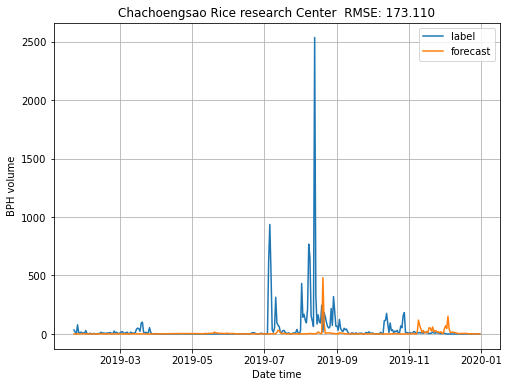

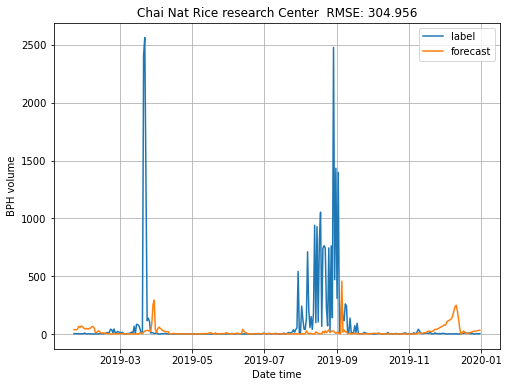

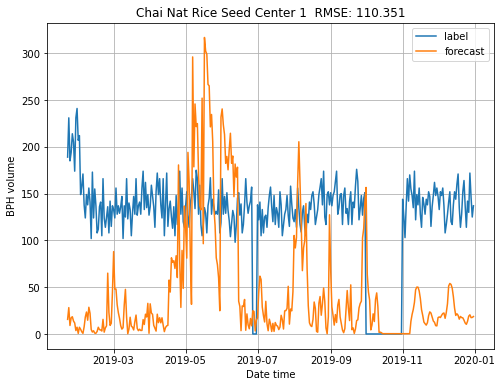

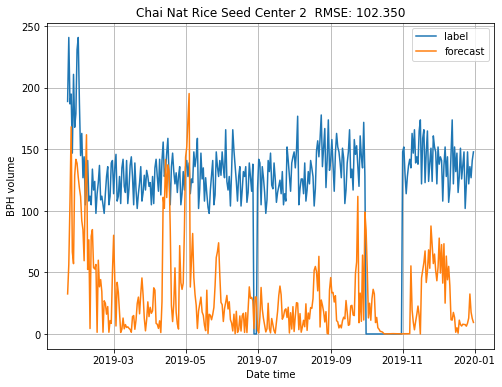

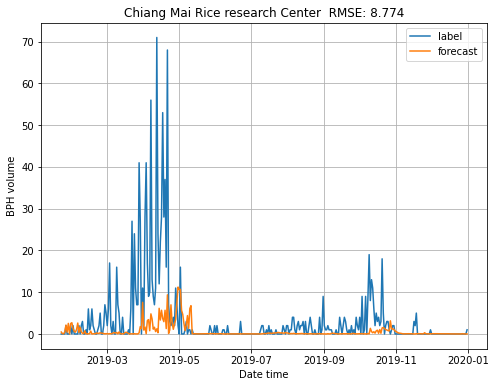

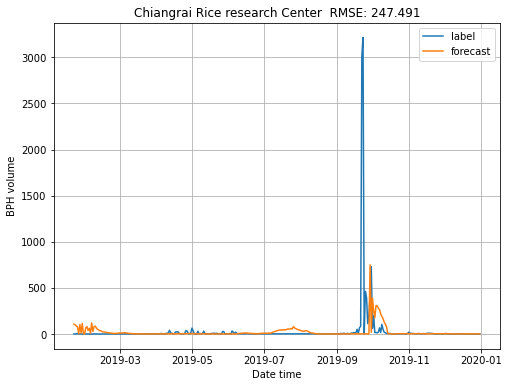

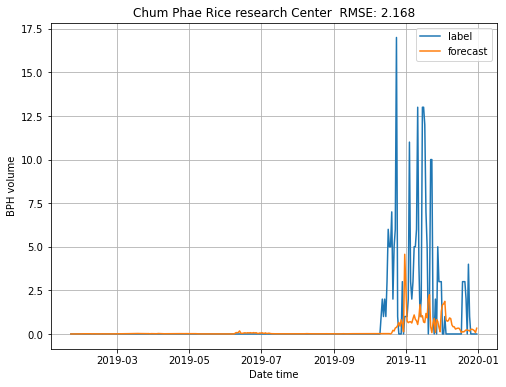

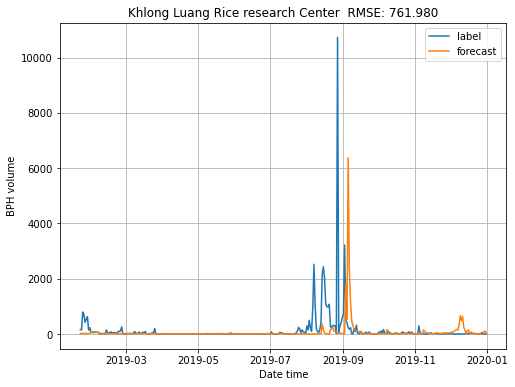

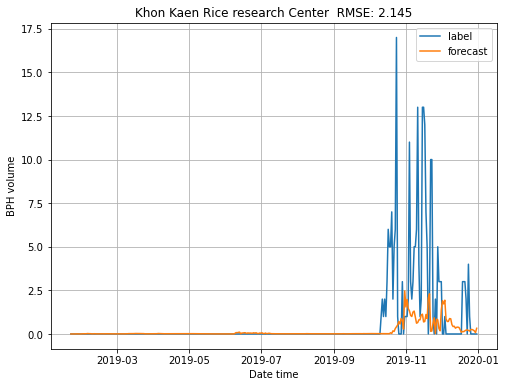

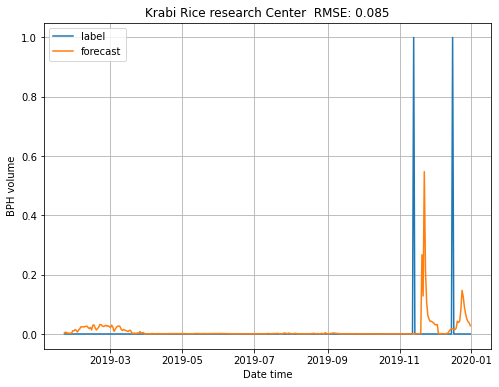

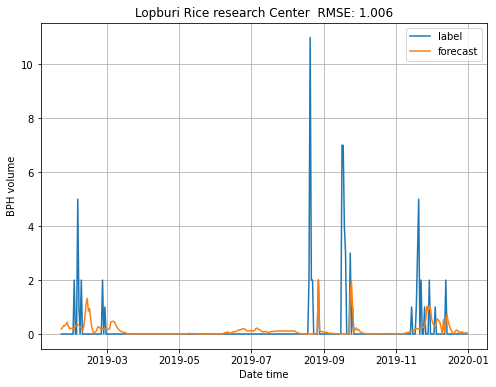

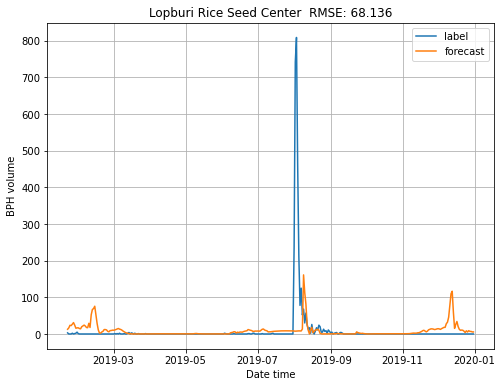

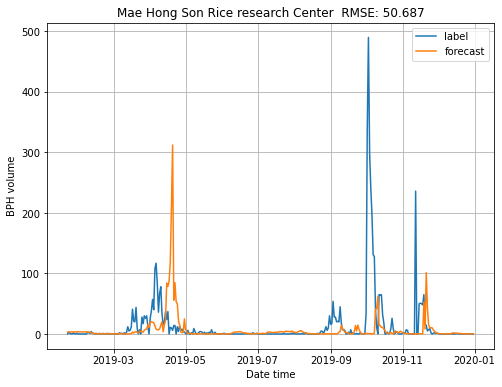

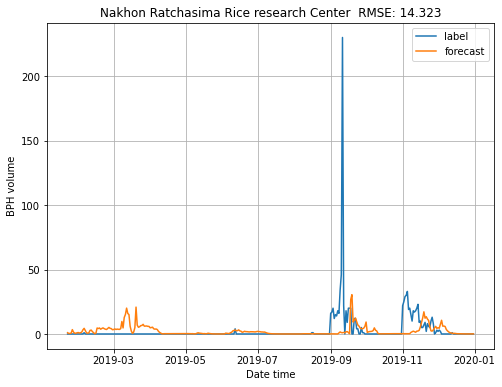

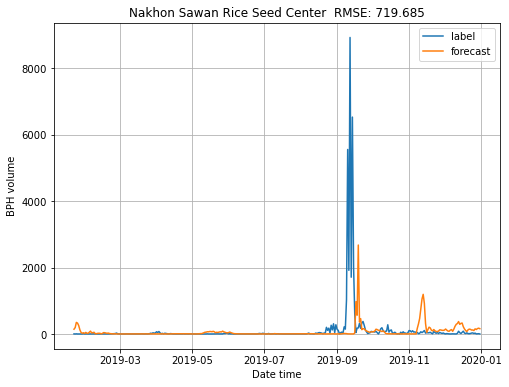

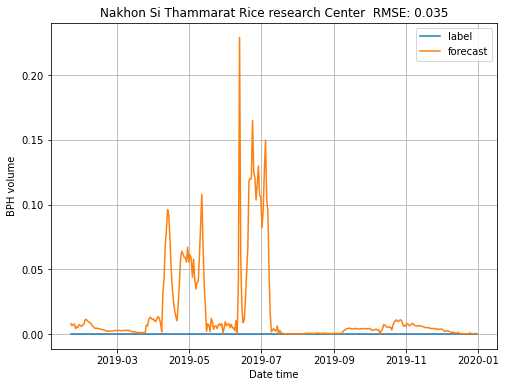

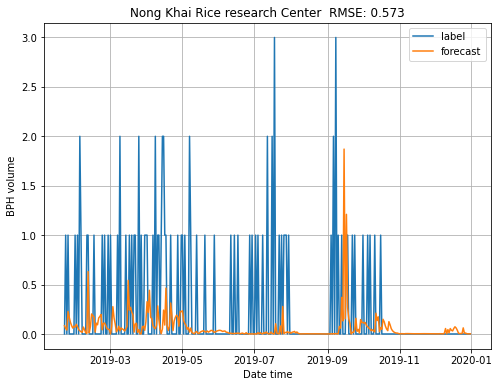

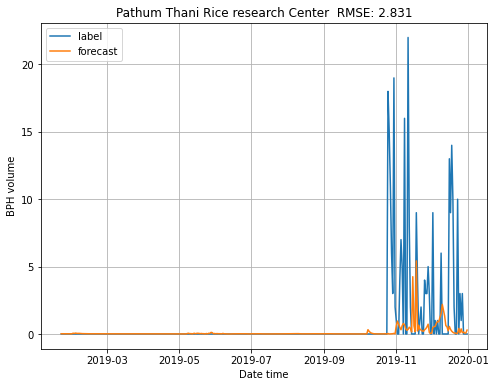

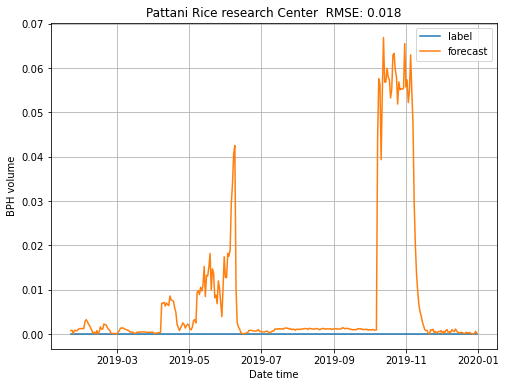

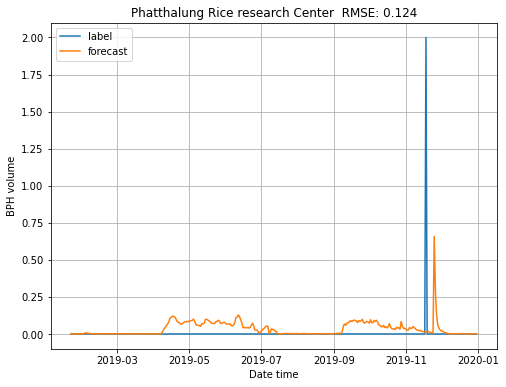

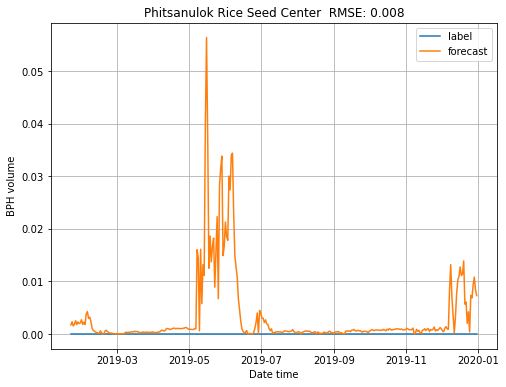

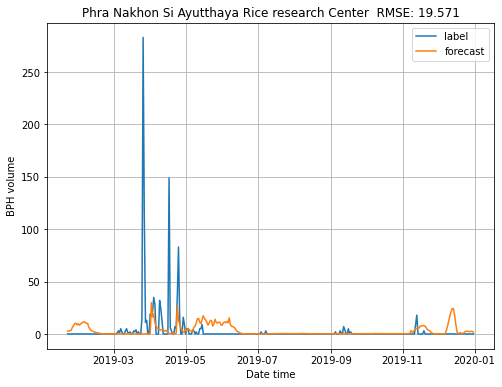

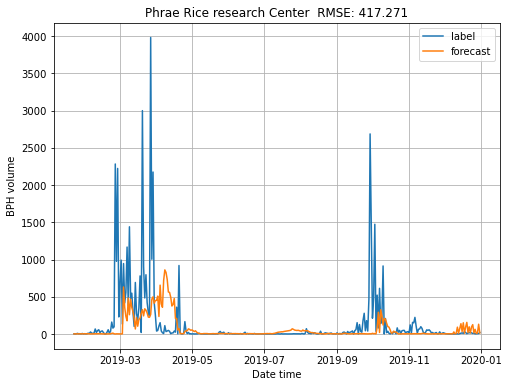

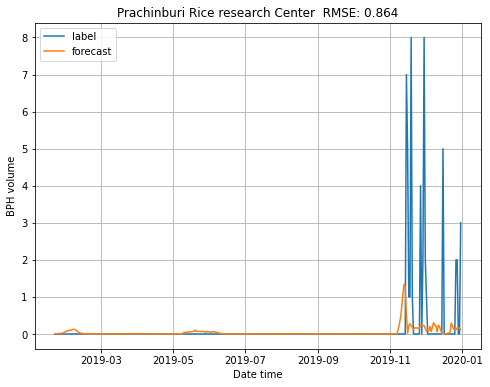

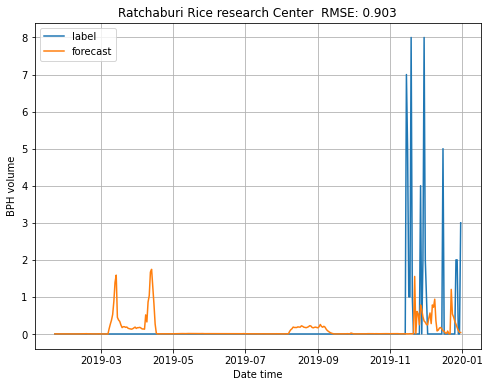

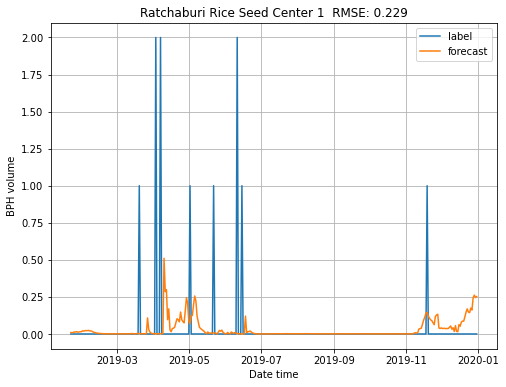

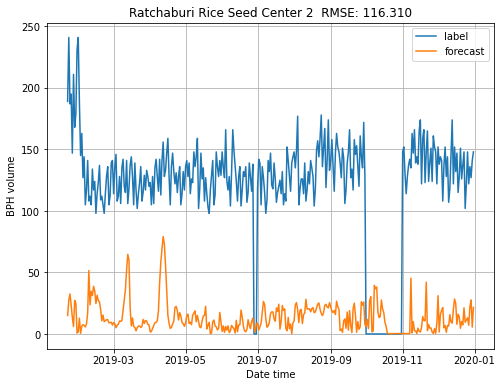

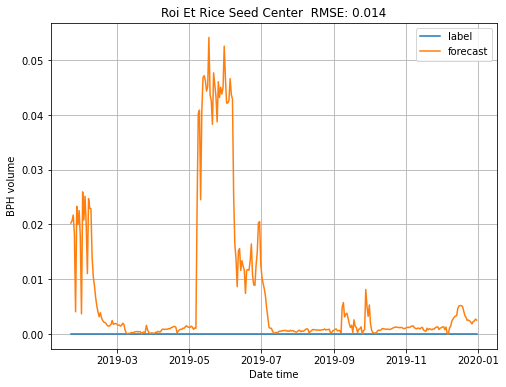

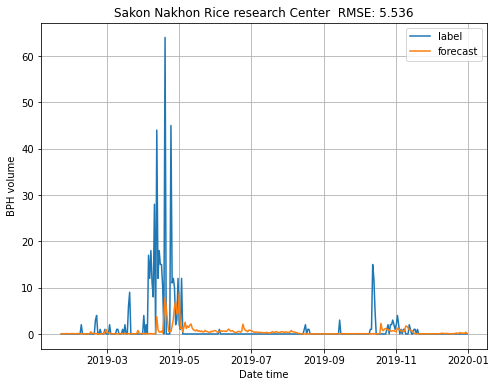

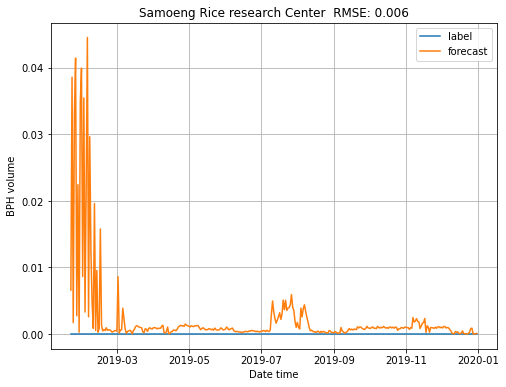

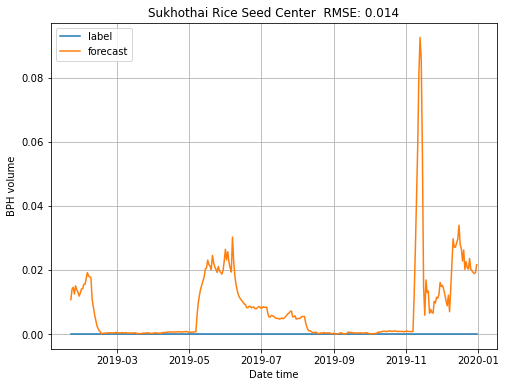

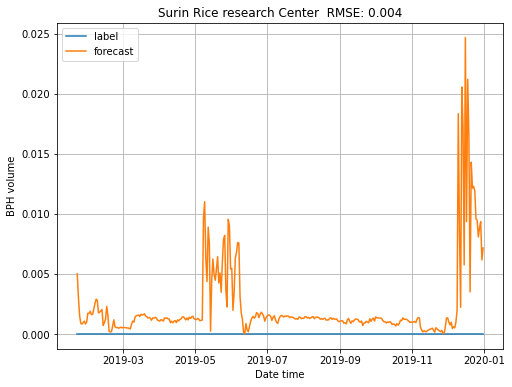

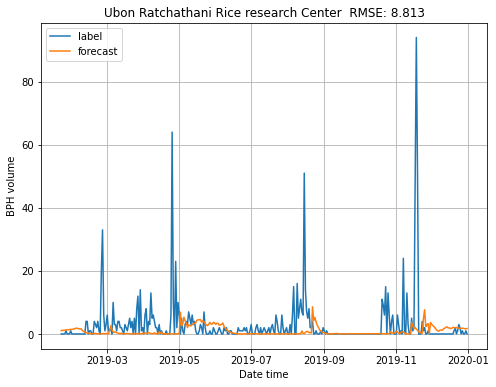

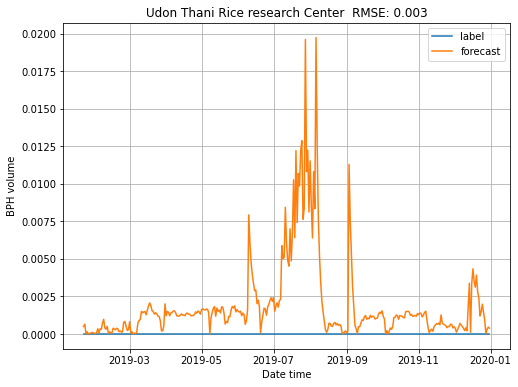

In [35]:

st = 0
mode_st = 0

y_pre_1 = '2019'
y_pre_2 = '2019'

list_mse = []
list_st = []
# for j in range(1):
for j in range(df_st.shape[0]):
    st = j
    frames_predict = creat_dataset(st,y_pre_1,y_pre_2,mode_st)
    values_predict = frames_predict.values    #ตัด header กับ idx ออก เป็น array matrix

    n_features = frames_predict.shape[1]

    if mode_st == 0:
        file_name = df_st['nameEng'][st]
    else:
        file_name = 'station_All'
    # from matplotlib import pyplot as plt
    # plot_data(frames_train,file_name)

    # plot_data(frames_validation,file_name)

    # plot_data(frames_predict,file_name)

    # /////////////////////////////////////--------/////////////////////////////////////////////////////#
    df = frames_predict.reset_index()
    date_time_predict = pd.to_datetime(df.pop('date'))

    # ////////////////////////////////////---------////////////////////////////////////////////////////#
    # ensure all data is float
    values = values_predict.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
        
    # frame as supervised learning
    reframed = series_to_supervised(scaled, n_day, n_out)
    # print(reframed.shape)
    # print(reframed.head())
        
    # predict datasets
    values = reframed.values
    # n_train_day = int(values.shape[0]*0.9)
    # train = values[:n_train_day, :]
    test = values
        
    # predict into input and outputs
    n_obs = n_day * n_features
    # test_X, test_y = test[:, :n_obs], test[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -1]
    print(test_X.shape, len(test_X), test_y.shape)
        
    # reshape input to be 3D [samples, timesteps, features]
    test_X = test_X.reshape((test_X.shape[0], n_day, n_features))
    print(test_X.shape, test_y.shape)
        
    # # make a prediction
    yhat = model_loaded.predict(test_X)
    test_X_reshape = test_X.reshape((test_X.shape[0], n_day*n_features))
        
    # invert scaling for forecast
    # inv_yhat = concatenate((yhat, test_X[:, -29:]), axis=1)
    inv_yhat = concatenate((test_X_reshape[:, :(n_features-1)], yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y_reshape = test_y.reshape((len(test_y), 1))
    # inv_y = concatenate((test_y, test_X[:, -29:]), axis=1)
    inv_y = concatenate((test_X_reshape[:, :(n_features-1)], test_y_reshape), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]

    forecast_data = (abs(inv_yhat[:])) 
    label_data =  inv_y[:]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(label_data,forecast_data))

    print('Test RMSE: %.3f' % rmse)

    # export_folder = Export_folder_name
    pre_name = df_st['nameEng'][st]
    plot_name = 'Performance'+pre_name+'.png'
    # plot history
    
    from matplotlib import pyplot as plt
    def plot_Perfor():
        plt.figure()
        plt.plot(date_time_predict[n_day+n_out-1:],label_data,label='label')
        plt.plot(date_time_predict[n_day+n_out-1:],forecast_data,label='forecast')
    
        plt.ylabel('BPH volume')
        plt.xlabel('Date time')
        plt.title(file_name +'  RMSE: %.3f' % rmse)
        plt.legend()
        plt.grid(True)
        # plt.show()

    plot_Perfor()
    
    Export_folder_name = "./Export_predict_BPH/"
    plot_name = str(st)+' plot_data-'+file_name+'-'+y_pre_1+'.png'
    plt.savefig(Export_folder_name + plot_name)

    #export csv
    df_out = pd.DataFrame(frames_predict.index) 
    df_out['address'] = pre_name
    df_out['latitude'] = df['latitude']
    df_out['longitude'] = df['longitude']
    df_out['bph label'] = df['bph']
    df_out['bph forecast'] = 0
    # df_out.iloc[14:,5]  = forecast_data.astype(int)    #for lag 1
    # df_out.iloc[16:,5]  = forecast_data.astype(int)    #for lag 3
    # df_out.iloc[18:,5]  = forecast_data.astype(int)    #for lag 5
    df_out.iloc[20:,5]  = forecast_data.astype(int)    #for lag 7
    
    list_mse.append(rmse)
    list_st.append(file_name)

    #Output : file name and Path Save file
    file_name_save = file_name+'-forecast-'+y_pre_1+'.csv'
    dataset_path_save = Export_folder_name + file_name_save
    df_out.to_csv(dataset_path_save, index=False, encoding="TIS-620")
    print("{} {}" .format(dataset_path_save,len(df_out)))
    del df_out

data_rmse = {'st_name': list_st,'rmse': list_mse}
df_rmse = pd.DataFrame(data_rmse)
  
 

In [36]:
#Output : file name and Path Save file
file_name_save_rmse = 'Model-forecast-RMSE '+path_adress_model_2[1:40]+'.csv'
dataset_path_save = Export_folder_name + file_name_save_rmse
df_rmse.to_csv(dataset_path_save, index=False, encoding="TIS-620")